In [47]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [48]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt

# Load the feature files and combine the features
features_ctl_s1 = pd.read_csv('../GSEA/miRNA/50_ctl_s1.csv')['Feature'].tolist()
features_s1_s2 = pd.read_csv('../GSEA/miRNA/50_s1_s2.csv')['Feature'].tolist()
features_s2_s3 = pd.read_csv('../GSEA/miRNA/50_s2_s3.csv')['Feature'].tolist()
features_s3_s4 = pd.read_csv('../GSEA/miRNA/50_s3_s4.csv')['Feature'].tolist()

all_selected_features = list(set(features_ctl_s1 + features_s1_s2 + features_s2_s3 + features_s3_s4))

print(len(all_selected_features))  # Ensure the total number of unique features

103


In [49]:
# Load and prepare the original stage data
ctl_samples = pd.read_csv('../data/control/control_samples.csv')
print(ctl_samples.shape)
ctl_samples.columns = ctl_samples.columns.str.strip()
ctl_samples = ctl_samples[ctl_samples['Sex'] == 'Sex: Male']
print(ctl_samples.shape)
stage_1_samples = pd.read_csv('../data/cancer/stage_1_prostate_cancer_samples.csv')
stage_2_samples = pd.read_csv('../data/cancer/stage_2_prostate_cancer_samples.csv')
stage_3_samples = pd.read_csv('../data/cancer/stage_3_prostate_cancer_samples.csv')
stage_4_samples = pd.read_csv('../data/cancer/stage_4_prostate_cancer_samples.csv')

# Add stage column for easier concatenation
ctl_samples['Stage'] = 'CTRL'
stage_1_samples['Stage'] = 'S1'
stage_2_samples['Stage'] = 'S2'
stage_3_samples['Stage'] = 'S3'
stage_4_samples['Stage'] = 'S4'

(5643, 2570)
(2468, 2570)


In [50]:

# Combine all stages data
combined_data = pd.concat([ctl_samples, stage_1_samples, stage_2_samples, stage_3_samples, stage_4_samples], ignore_index=True)

# Ensure only numeric columns are used
numeric_columns = combined_data.columns.drop(['Sample_ID', 'Sex', 'Age', 'Stage', 'Disease'])

# Calculate the average expression levels for each miRNA for each stage
average_expression = combined_data.groupby('Stage')[numeric_columns].mean().T

# Ensure all selected features are present in the data
selected_features_in_data = [feature for feature in all_selected_features if feature in average_expression.index]

print("Features present in data:", len(selected_features_in_data))

# Print missing features
missing_features = set(all_selected_features) - set(selected_features_in_data)
if missing_features:
    print("Missing features:", missing_features)

# Extract the selected features from the average expression data
selected_expression = average_expression.loc[selected_features_in_data]

# Normalize each miRNA across stages
normalized_expression = selected_expression.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Check if the normalization removes any miRNAs
print("Normalized expression shape:", normalized_expression.shape)

Features present in data: 103
Normalized expression shape: (103, 5)


<Figure size 1500x1000 with 0 Axes>

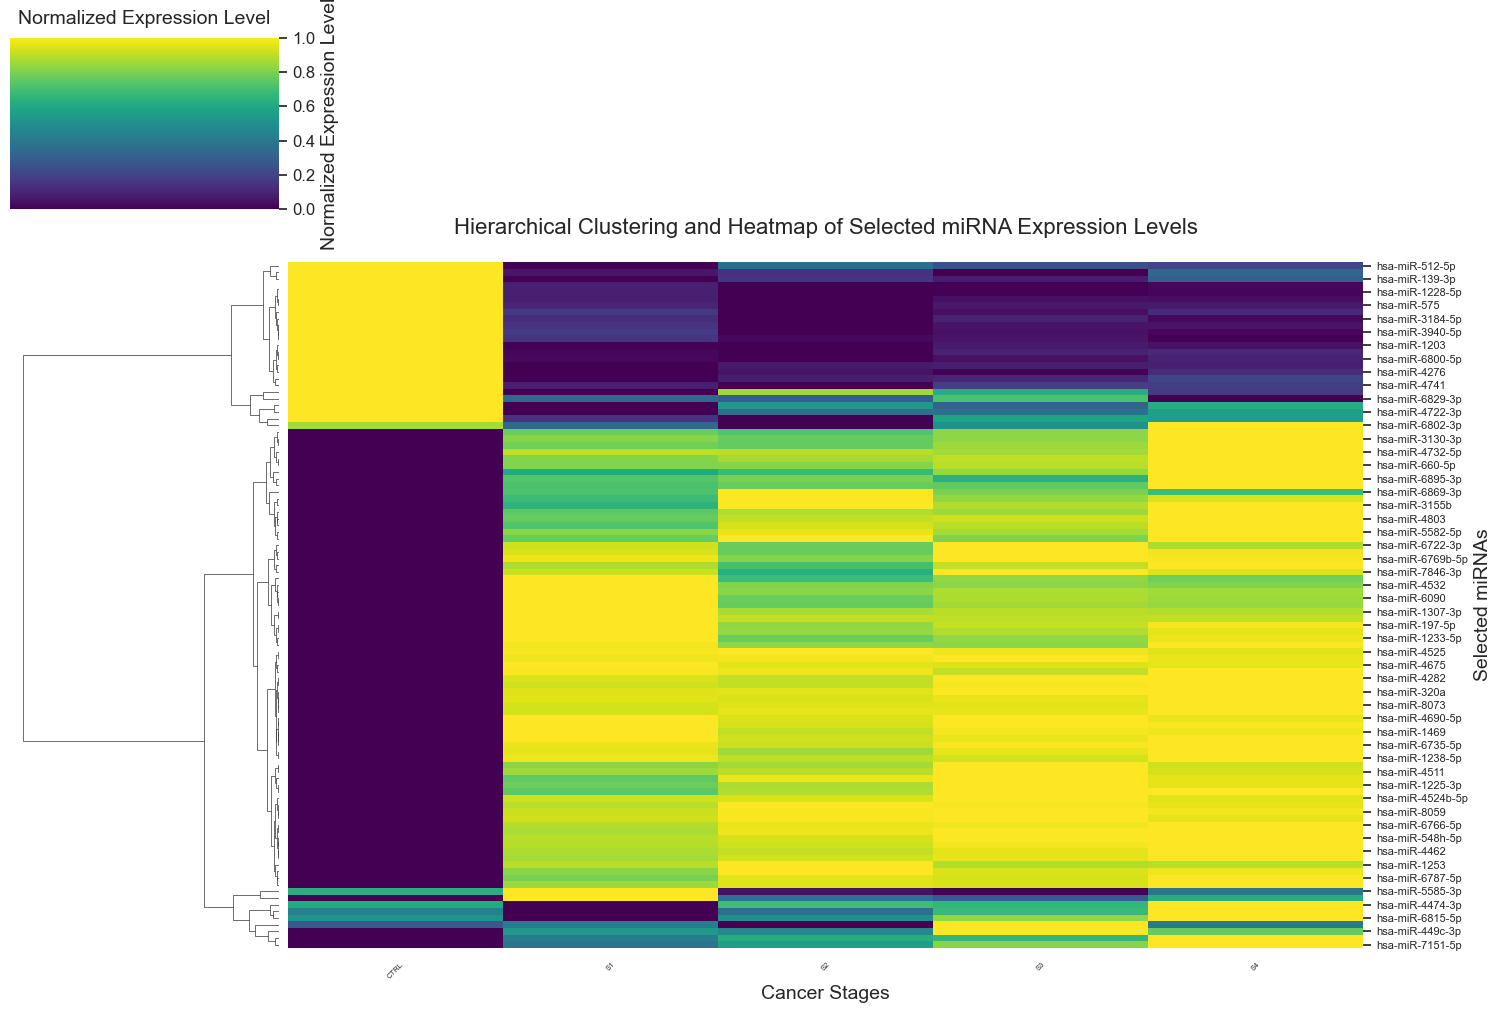

In [51]:
# Perform hierarchical clustering on the normalized data
linked = linkage(normalized_expression, method='ward')

# Create a heatmap with dendrogram
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)  # Reduce font scale for better visibility
clustermap = sns.clustermap(normalized_expression, row_linkage=linked, col_cluster=False, cmap='viridis', figsize=(15, 10))

# Enhance the heatmap
clustermap.ax_heatmap.set_title('Hierarchical Clustering and Heatmap of Selected miRNA Expression Levels', fontsize=16, pad=20)
clustermap.ax_heatmap.set_xlabel('Cancer Stages', fontsize=14)
clustermap.ax_heatmap.set_ylabel('Selected miRNAs', fontsize=14)
clustermap.ax_heatmap.tick_params(axis='x', rotation=45)

# Set y-tick labels to ensure all miRNAs are displayed
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)  # Adjust fontsize for y-tick labels

# Add color bar legend with a title
cbar = clustermap.ax_heatmap.collections[0].colorbar
cbar.set_label('Normalized Expression Level', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set color bar title
cbar.ax.set_title('Normalized Expression Level', fontsize=14, pad=10)

plt.tight_layout()

# Save the figure
# plt.savefig('../data/heatmap_clustering_normalized_all_features.png')
plt.show()

- For each of the 7 different groups from hierarchical clustering, choose one miRNA and perform analysis on it to give a sample from that group
	- ANOVA Statistical Analysis
	- Post HOC Analysis
	- Plot expression over groups using bar plot

## Random Sampling From the 7 Clusters

In [52]:
# import pandas as pd
# import seaborn as sns
# from scipy.cluster.hierarchy import fcluster
# from scipy.stats import f_oneway
# import matplotlib.pyplot as plt
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Assign clusters
# num_clusters = 7
# clusters = fcluster(linked, num_clusters, criterion='maxclust')

# # Sample one miRNA from each cluster
# sampled_miRNAs = []
# for cluster_id in range(1, num_clusters + 1):
#     cluster_miRNAs = normalized_expression.index[clusters == cluster_id]
#     sampled_miRNA = cluster_miRNAs[0]  # Select the first miRNA in the cluster
#     sampled_miRNAs.append(sampled_miRNA)

# print("Sampled miRNAs from each cluster:", sampled_miRNAs)

# # Perform ANOVA and Post Hoc analysis on normalized data
# for miRNA in sampled_miRNAs:
#     miRNA_data = combined_data[['Stage', miRNA]]
#     miRNA_data = miRNA_data.dropna()

#     # Normalize within each miRNA across all stages
#     miRNA_data['Normalized'] = miRNA_data.groupby('Stage')[miRNA].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

#     # ANOVA on normalized data
#     anova_result = f_oneway(
#         miRNA_data[miRNA_data['Stage'] == 'Stage 1']['Normalized'],
#         miRNA_data[miRNA_data['Stage'] == 'Stage 2']['Normalized'],
#         miRNA_data[miRNA_data['Stage'] == 'Stage 3']['Normalized'],
#         miRNA_data[miRNA_data['Stage'] == 'Stage 4']['Normalized']
#     )

#     print(f"ANOVA result for {miRNA}: F={anova_result.statistic}, p={anova_result.pvalue}")

#     # Post Hoc Analysis with Tukey HSD on normalized data
#     tukey_result = pairwise_tukeyhsd(endog=miRNA_data['Normalized'], groups=miRNA_data['Stage'], alpha=0.05)
#     print(tukey_result)

#     # Plot normalized expression over groups using bar plot
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='Stage', y='Normalized', data=miRNA_data, ci='sd')
#     plt.title(f'Normalized Expression of {miRNA} across Cancer Stages')
#     plt.xlabel('Cancer Stages')
#     plt.ylabel('Normalized Expression Level')
#     plt.tight_layout()
#     plt.show()

## Specific Sampling from the 7 Clusters

/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


ANOVA result for hsa-miR-548h-5p: F=nan, p=nan
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL     S1   0.1167    0.0  0.0819  0.1515   True
  CTRL     S2    0.052    0.0   0.028  0.0759   True
  CTRL     S3   0.1244    0.0  0.0872  0.1616   True
  CTRL     S4   0.0961    0.0  0.0489  0.1434   True
    S1     S2  -0.0647 0.0001 -0.1051 -0.0244   True
    S1     S3   0.0077 0.9933 -0.0417   0.057  False
    S1     S4  -0.0206 0.8643 -0.0779  0.0367  False
    S2     S3   0.0724    0.0    0.03  0.1148   True
    S2     S4   0.0442 0.1314 -0.0073  0.0956  False
    S3     S4  -0.0282 0.6843  -0.087  0.0305  False
----------------------------------------------------


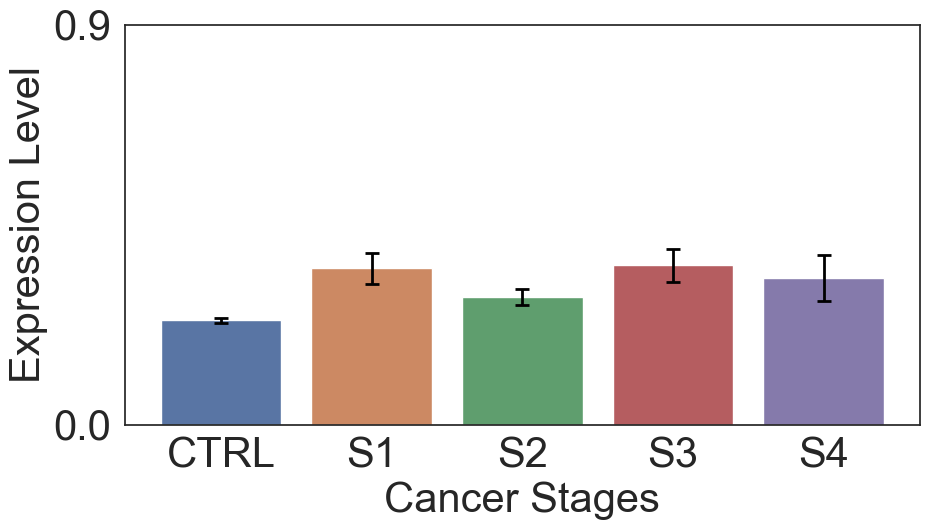

ANOVA result for hsa-miR-6769b-5p: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL     S1   0.0006    1.0 -0.0182  0.0195  False
  CTRL     S2   0.0891    0.0  0.0761  0.1021   True
  CTRL     S3  -0.0838    0.0 -0.1039 -0.0636   True
  CTRL     S4   -0.121    0.0 -0.1466 -0.0954   True
    S1     S2   0.0885    0.0  0.0666  0.1104   True
    S1     S3  -0.0844    0.0 -0.1111 -0.0576   True
    S1     S4  -0.1216    0.0 -0.1526 -0.0905   True
    S2     S3  -0.1729    0.0 -0.1959 -0.1499   True
    S2     S4  -0.2101    0.0  -0.238 -0.1822   True
    S3     S4  -0.0372 0.0125 -0.0691 -0.0054   True
----------------------------------------------------


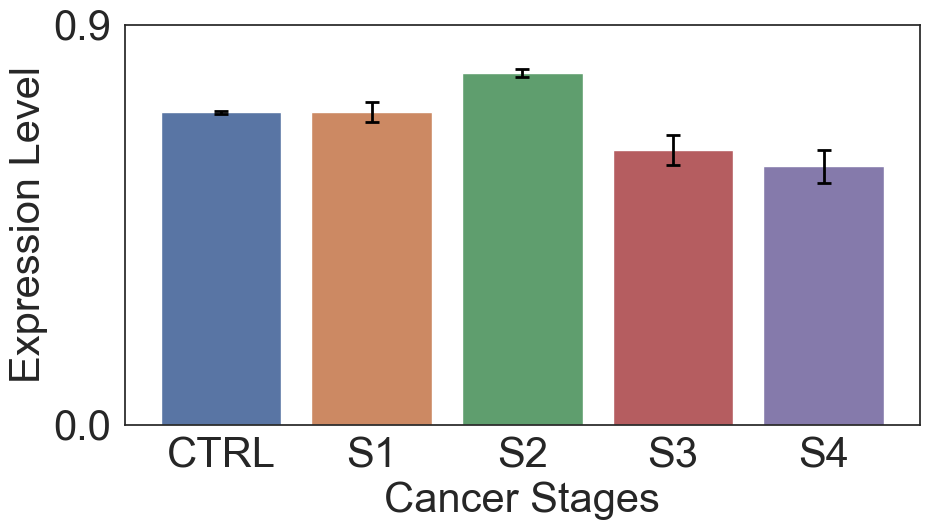

In [70]:
miRNAs_to_analyze = ['hsa-miR-548h-5p', 'hsa-miR-6769b-5p']

sns.set_style("white")

plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('font', size=30)     

# Perform ANOVA and Post Hoc analysis on specified miRNAs
for miRNA in miRNAs_to_analyze:
    miRNA_data = combined_data[['Stage', miRNA]]
    miRNA_data = miRNA_data.dropna()

    # Normalize within each miRNA across all stages
    miRNA_data['Normalized'] = miRNA_data.groupby('Stage')[miRNA].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # ANOVA on normalized data
    anova_result = f_oneway(
        miRNA_data[miRNA_data['Stage'] == 'Control ']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 1']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 2']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 3']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 4']['Normalized']
    )

    print(f"ANOVA result for {miRNA}: F={anova_result.statistic}, p={anova_result.pvalue}")

    # Post Hoc Analysis with Tukey HSD on normalized data
    tukey_result = pairwise_tukeyhsd(endog=miRNA_data['Normalized'], groups=miRNA_data['Stage'], alpha=0.05)
    print(tukey_result)

    mean_data = miRNA_data.groupby('Stage')['Normalized'].mean().reset_index()
    sem_data = miRNA_data.groupby('Stage')['Normalized'].sem().reset_index()
    mean_data['2*SEM'] = 2 * sem_data['Normalized']

    # Plot normalized expression over groups using bar plot
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Stage', y='Normalized', data=mean_data)
    
    # Add error bars with horizontal caps
    for i, stage in enumerate(mean_data['Stage']):
        plt.errorbar(
            x=i, 
            y=mean_data.loc[i, 'Normalized'], 
            yerr=mean_data.loc[i, '2*SEM'], 
            fmt='none', 
            c='black', 
            capsize=5, 
            capthick=2, 
            elinewidth=2  # Increase the error bar line width
        )

    plt.xlabel('Cancer Stages', fontsize=30)
    plt.ylabel('Expression Level', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.yticks([0, 0.9])
    plt.tight_layout()
    plt.show()